In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

# Load the best saved model
best_model = tf.keras.models.load_model("pen_to_pixel_colab.keras")

# Evaluate on full test set
test_loss, test_acc = best_model.evaluate(ds_test)
print(f"✅ Final EMNIST Digits Test Accuracy: {test_acc*100:.2f}%")

# Get some test samples
for images, labels in ds_test.take(1):  # Take 1 batch from test set
    preds = best_model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    # Show first 10 samples
    plt.figure(figsize=(12, 3))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title(f"True: {labels[i].numpy()}\nPred: {pred_labels[i]}")
        plt.axis("off")
    plt.show()


2025-09-06 19:05:15.100684: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 19:05:15.173995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-06 19:05:16.989618: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 19:05:18.808816: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


NameError: name 'ds_test' is not defined

Loaded model from: /home/patil/pen_to_pixel_colab.keras
Model expects input shape: (64, 64, 1)


2025-09-06 21:20:47.299799: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Test accuracy: 76.55% (2000 samples)

Classification report (truncated):
              precision    recall  f1-score   support

           0      0.742     0.759     0.750        87
           1      0.755     0.913     0.827       115
           2      1.000     0.977     0.988       130
           3      1.000     1.000     1.000       119
           4      0.989     0.978     0.983        89
           5      0.990     0.951     0.970       103
           6      1.000     0.990     0.995        97
           7      1.000     1.000     1.000       104
           8      0.977     0.988     0.983        86
           9      0.951     0.990     0.970        99
          10      1.000     1.000     1.000        19
          11      1.000     1.000     1.000         8
          12      0.773     1.000     0.872        34
          13      1.000     1.000     1.000        22
          14      1.000     1.000     1.000        15
          15      0.857     0.889     0.873        27
       

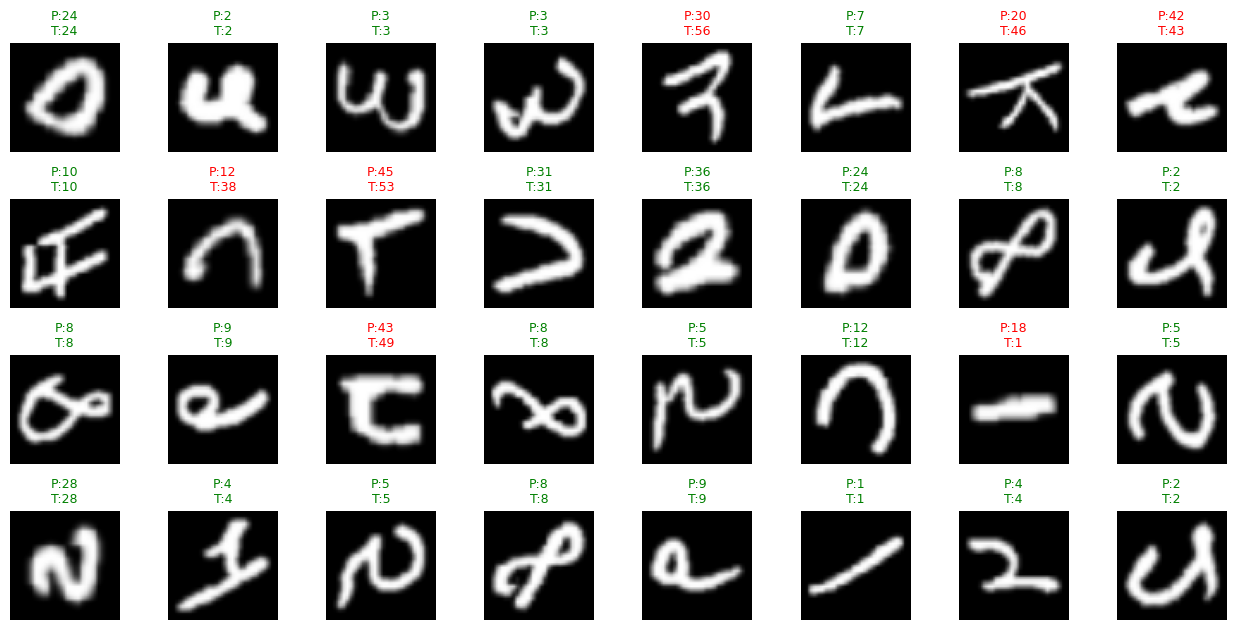

In [6]:
# test_emnist_model_light.py
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

MODEL_PATH = "/home/patil/pen_to_pixel_colab.keras"   
EMNIST_SPLIT = "byclass"   # "byclass" = all subclasses
BATCH_SIZE = 64
IMG_PLOT_ROWS = 4
IMG_PLOT_COLS = 8
MAX_TEST_SAMPLES = 2000    # <-- limit to 2000 samples for speed; set None for full test set

def load_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model path not found: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print("Loaded model from:", model_path)
    return model

def preprocess_image(image, label, model_input_shape):
    image = tf.cast(image, tf.float32) / 255.0
    if image.shape.rank == 2:
        image = tf.expand_dims(image, -1)
    desired_channels = model_input_shape[-1]
    if desired_channels == 3 and image.shape[-1] == 1:
        image = tf.tile(image, [1,1,3])
    h, w = model_input_shape[0], model_input_shape[1]
    if image.shape[0] != h or image.shape[1] != w:
        image = tf.image.resize(image, (h, w))
    return image, label

def load_emnist_test(split_name="byclass", batch_size=256, max_samples=None, model_input_shape=(28,28,1)):
    # 🚀 load only the test split (no train building)
    test_ds, info = tfds.load(f"emnist/{split_name}", split="test", as_supervised=True, with_info=True)
    preprocess_fn = lambda img, lbl: preprocess_image(img, lbl, model_input_shape)
    test_ds = test_ds.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if max_samples:
        test_ds = test_ds.take(max_samples)
    test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    label_feature = info.features["label"]
    int2str = label_feature.int2str if hasattr(label_feature, "int2str") else lambda i: str(i)
    return test_ds, info, int2str

def evaluate_and_plot(model, test_ds, int2str, rows=4, cols=8):
    y_true, y_pred, images_for_plot = [], [], []
    for batch in test_ds:
        imgs, labels = batch
        preds = model.predict(imgs, verbose=0)
        pred_classes = np.argmax(preds, axis=-1)
        y_true.extend(labels.numpy().tolist())
        y_pred.extend(pred_classes.tolist())
        if len(images_for_plot) < rows*cols:
            images_for_plot.extend(imgs.numpy().tolist())

    acc = accuracy_score(y_true, y_pred)
    print(f"\nTest accuracy: {acc*100:.2f}% ({len(y_true)} samples)")
    print("\nClassification report (truncated):")
    print(classification_report(y_true, y_pred, zero_division=0, digits=3))

    # Plot grid of predictions
    n_plot = rows * cols
    plt.figure(figsize=(cols*1.6, rows*1.6))
    for i in range(min(n_plot, len(images_for_plot))):
        img = np.array(images_for_plot[i])
        true_label = int2str(int(y_true[i]))
        pred_label = int2str(int(y_pred[i]))
        ax = plt.subplot(rows, cols, i + 1)
        if img.shape[-1] == 1:
            plt.imshow(img.squeeze(-1), cmap="gray")
        else:
            plt.imshow(img)
        ax.set_title(f"P:{pred_label}\nT:{true_label}", color="green" if y_true[i]==y_pred[i] else "red", fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def main():
    model = load_model(MODEL_PATH)
    input_shape = model.input_shape
    if isinstance(input_shape, list): input_shape = input_shape[0]
    model_input_shape = input_shape[1:] if input_shape[0] is None else tuple(x for x in input_shape if x)
    if len(model_input_shape) == 2:
        model_input_shape = (model_input_shape[0], model_input_shape[1], 1)
    print("Model expects input shape:", model_input_shape)

    test_ds, info, int2str = load_emnist_test(split_name=EMNIST_SPLIT,
                                              batch_size=BATCH_SIZE,
                                              max_samples=MAX_TEST_SAMPLES,
                                              model_input_shape=model_input_shape)
    evaluate_and_plot(model, test_ds, int2str, rows=IMG_PLOT_ROWS, cols=IMG_PLOT_COLS)

if __name__ == "__main__":
    main()
